In [89]:
import json
import plotly.express as px
import plotly.graph_objects as go
import folium

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from PIL import Image
from IPython.display import IFrame
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D

import glob
import logging
import pyogrio
import geopandas as gpd
import pyogrio
import fiona
from fiona.crs import from_epsg
from osgeo import gdal

Public data from https://www.liepaja.lv/dokumenti/statistikas-raditaji-izglitiba/   
(Total children and Children in kindergardens per neighborhood)

## Plotly on geomap

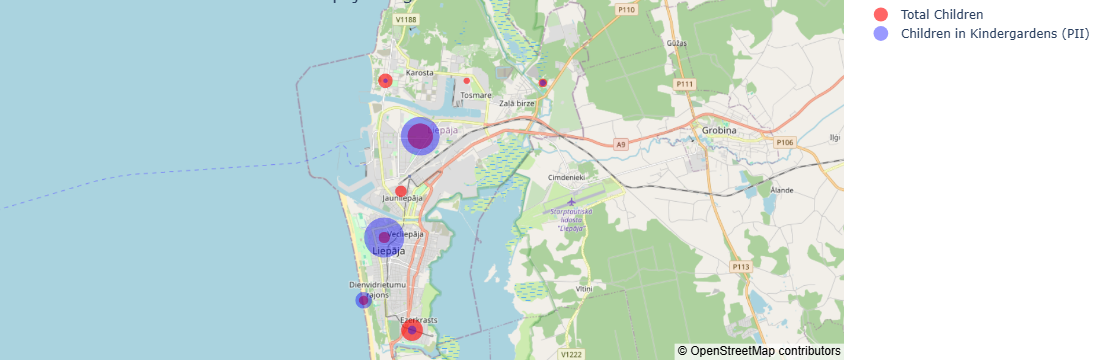

In [88]:
# Neighborhood data with approximate coordinates
data = {
    'Rajons': ['Dienvidrietumu', 'Ezerkrasts', 'Vecliepāja', 'Jaunliepāja', 
               'Ziemeļu priekšpilsēta', 'Karosta', 'Tosmare', 'Zaļā birze'],
    'PII': [515, 277, 1220, 0, 1180, 151, 0, 200],
    'Total': [296, 667, 356, 361, 780, 448, 208, 280],
    'Latitude': [56.4912, 56.4832, 56.5080, 56.5204, 56.53516, 56.5500, 56.5500, 56.5494],
    'Longitude': [20.9950, 21.0185, 21.0050, 21.0131, 21.022455, 21.0056, 21.0451, 21.0820]}

df = pd.DataFrame(data)

# Create a scatter map
fig = go.Figure()

# Add markers for Total children
fig.add_trace(go.Scattermapbox(
    lat=df['Latitude'],
    lon=df['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=df['Total'] / 30,  # Scale marker size for visibility
        color='red',
        opacity=0.6
    ),
    text=df.apply(lambda row: f"Neighborhood: {row['Rajons']}<br>Total: {row['Total']}", axis=1),
    name='Total Children'
))

# Add markers for PII (children in kindergardens)
fig.add_trace(go.Scattermapbox(
    lat=df['Latitude'],
    lon=df['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=df['PII'] / 30,  # Scale marker size for visibility
        color='blue',
        opacity=0.4
    ),
    text=df.apply(lambda row: f"Neighborhood: {row['Rajons']}<br>PII: {row['PII']}", axis=1),
    name='Children in Kindergardens (PII)'
))

# Update layout for map
fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        zoom=10.5,
        center=dict(lat=df['Latitude'].mean(), lon=df['Longitude'].mean())
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
    title="Children and Schools Data in Liepāja Neighborhoods"
)

# Show the figure
fig.show()

## Scatter Plot

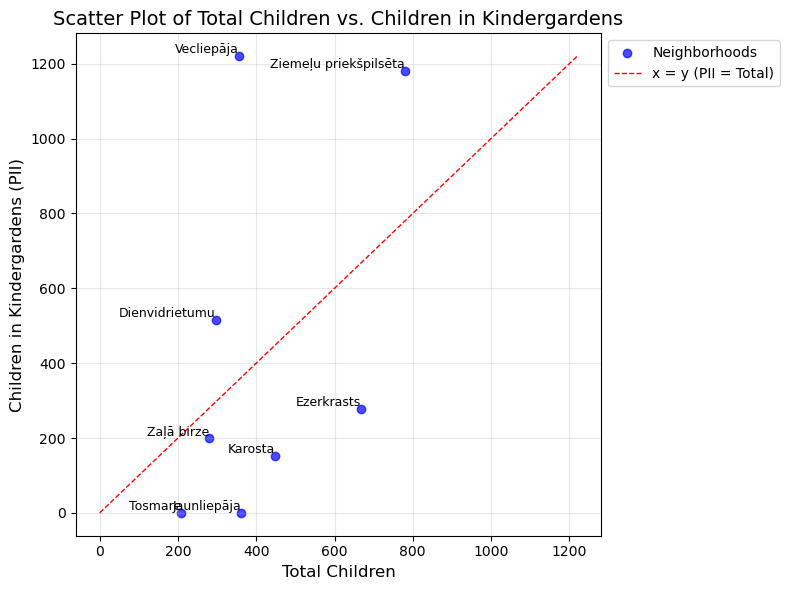

In [4]:
# Data
data = {
    'Rajons': ['Dienvidrietumu', 'Ezerkrasts', 'Vecliepāja', 'Jaunliepāja', 
               'Ziemeļu priekšpilsēta', 'Karosta', 'Tosmare', 'Zaļā birze'],
    'PII': [515, 277, 1220, 0, 1180, 151, 0, 200],
    'Total': [296, 667, 356, 361, 780, 448, 208, 280]
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(df['Total'], df['PII'], color='blue', alpha=0.7, label='Neighborhoods')

# Add labels for each neighborhood
for i, row in df.iterrows():
    plt.text(row['Total'], row['PII'], row['Rajons'], fontsize=9, ha='right', va='bottom')

# Add x = y diagonal line
max_value = max(df['Total'].max(), df['PII'].max())
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', linewidth=1, label='x = y (PII = Total)')

# Add titles and labels
plt.title('Scatter Plot of Total Children vs. Children in Kindergardens', fontsize=14)
plt.xlabel('Total Children', fontsize=12)
plt.ylabel('Children in Kindergardens (PII)', fontsize=12)

# Place legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

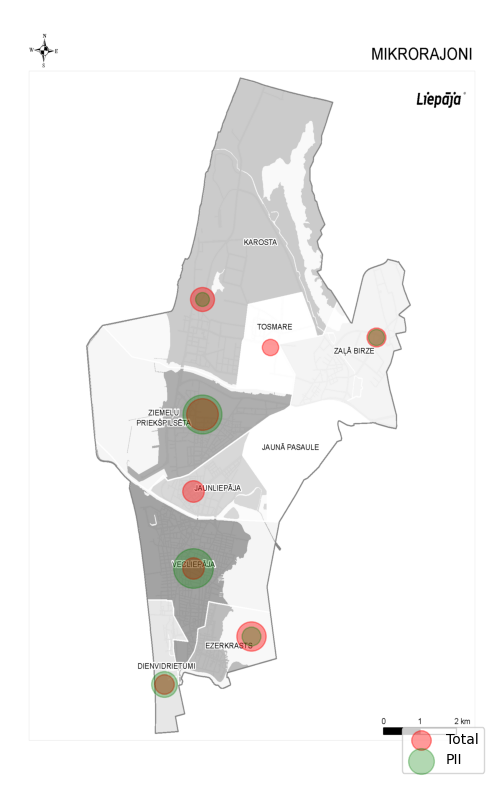

In [74]:
# Data
data = {
    'Rajons': ['Dienvidrietumu', 'Ezerkrasts', 'Vecliepāja', 'Jaunliepāja', 
               'Ziemeļu priekšpilsēta', 'Karosta', 'Tosmare', 'Zaļā birze'],
    'PII': [515, 277, 1220, 0, 1180, 151, 0, 200],
    'Total': [296, 667, 356, 361, 780, 448, 208, 280],
    # Manually estimated pixel positions on the map
    'x_pixel': [160, 250, 190, 190, 200, 200, 270, 380],
    'y_pixel': [100, 150, 220, 300, 380, 500, 450, 460]
}

df = pd.DataFrame(data)

# Load the map image
map_image = Image.open("Mikrorajoni_robezas_LiepajaBW.png")

# Create a plot
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(map_image, extent=[0, 500, 0, 800])  # Adjust extent as necessary

# Overlay data
for i, row in df.iterrows():
    # Plot PII and Total, /1.5 to adjust the bubble size
    ax.scatter(row['x_pixel'], row['y_pixel'], s=row['Total'] / 1.5, color='red', alpha=0.4, label='Total' if i == 0 else "", marker='o')
    ax.scatter(row['x_pixel'], row['y_pixel'], s=row['PII'] / 1.5, color='green', alpha=0.3, label='PII' if i == 0 else "", marker='o')
    # ax.text(row['x_pixel'], row['y_pixel'], row['Rajons'], fontsize=9, ha='center', color='white')

# legend
ax.axis('off')  # Hide axes
ax.legend(loc='lower right')

plt.show()

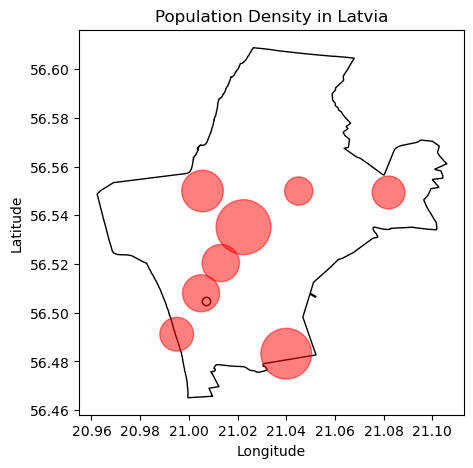

In [75]:
# Create a GeoDataFrame
data = pd.read_csv('PII.csv')

geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
gdf = gpd.GeoDataFrame(data, geometry=geometry)
latvia_shapefile = 'overpass-turbo-Liepaja.geojson'
latvia = gpd.read_file(latvia_shapefile)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot the base map of Latvia
latvia.plot(ax=ax, color='white', edgecolor='black')

# Plot the population density data
gdf.plot(ax=ax, marker='o', color='red', markersize=gdf['Total']*2, alpha=0.5)

plt.title('Population Density in Latvia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### An alternative approach using just the GeoJSON file and plotly, which doesn't require fiona or pyogrio

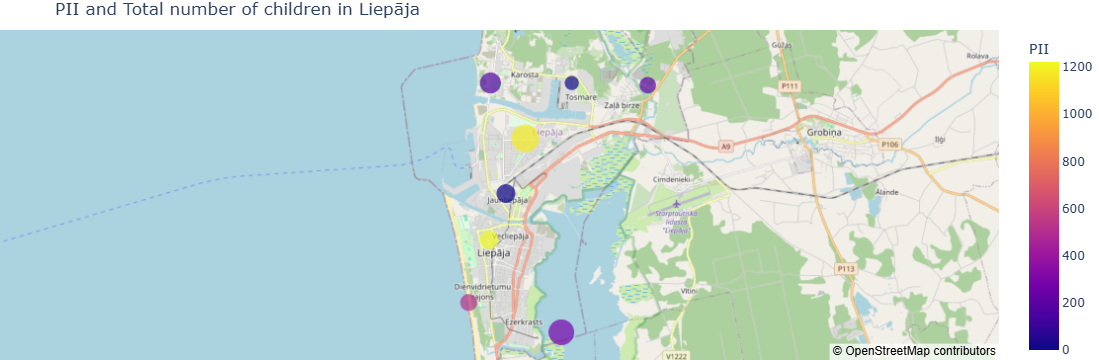

In [86]:
# Read GeoJSON file
with open('overpass-turbo-Liepaja.geojson', 'r', encoding='utf-8') as f:
    liepaja_geojson = json.load(f)

# Create DataFrame from your data
data = pd.read_csv('PII.csv')

# Create figure
fig = px.scatter_mapbox(data, 
                       lat='latitude', 
                       lon='longitude',
                       size='Total',
                       color='PII',
                       hover_name='Rajons',
                       hover_data=['Total'],
                       zoom=10.5,
                       title='PII and Total number of children in Liepāja')

# Update layout
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(
        center=dict(lat=56.52, lon=21.0100),  # Liepāja center coordinates
    ),
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()

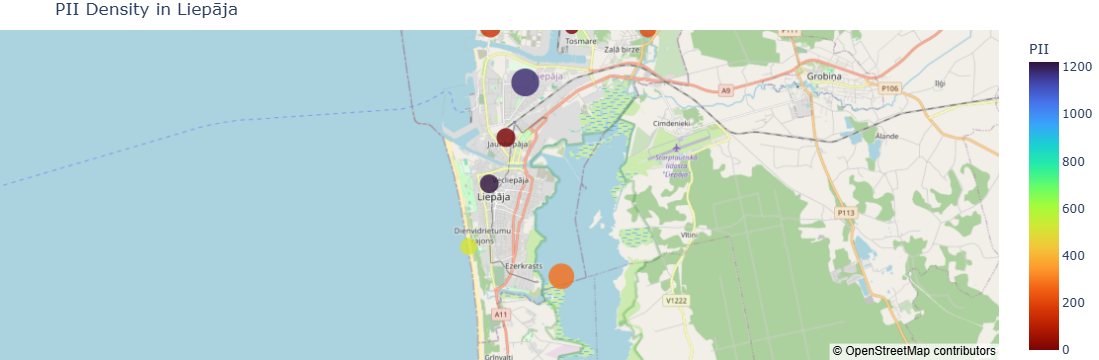

In [80]:
# Read GeoJSON file
with open('overpass-turbo-Liepaja.geojson', 'r', encoding='utf-8') as f:
    liepaja_geojson = json.load(f)

# Create DataFrame from your data
data = pd.read_csv('PII.csv')

# Create figure
fig = px.scatter_mapbox(data, 
                       lat='latitude', 
                       lon='longitude',
                       size='Total',
                       color='PII',
                       hover_name='Rajons',  # adjust column name if different
                       hover_data=['Total'],
                       zoom=10.5,
                       title='PII Density in Liepāja',
                       color_continuous_scale=px.colors.sequential.Turbo[::-1], # Reverse the color scale
                        opacity=0.8)

# Update layout
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(
        center=dict(lat=56.5050, lon=21.0100),  # Liepāja center coordinates
    ),
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()

### with Fiona

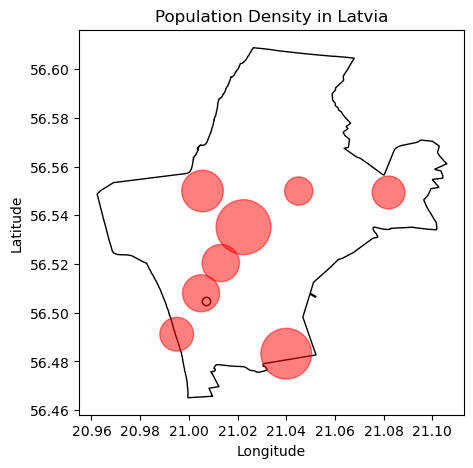

In [22]:
# Create a GeoDataFrame
data = pd.read_csv('PII.csv')
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
gdf = gpd.GeoDataFrame(data, geometry=geometry)
latvia_shapefile = 'overpass-turbo-Liepaja.geojson'
latvia = gpd.read_file(latvia_shapefile)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# Plot the base map of Latvia
latvia.plot(ax=ax, color='white', edgecolor='black')
# Plot the population density data
gdf.plot(ax=ax, marker='o', color='red', markersize=gdf['Total']*2, alpha=0.5)
plt.title('Population Density in Latvia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### The simplest version with Plotly express

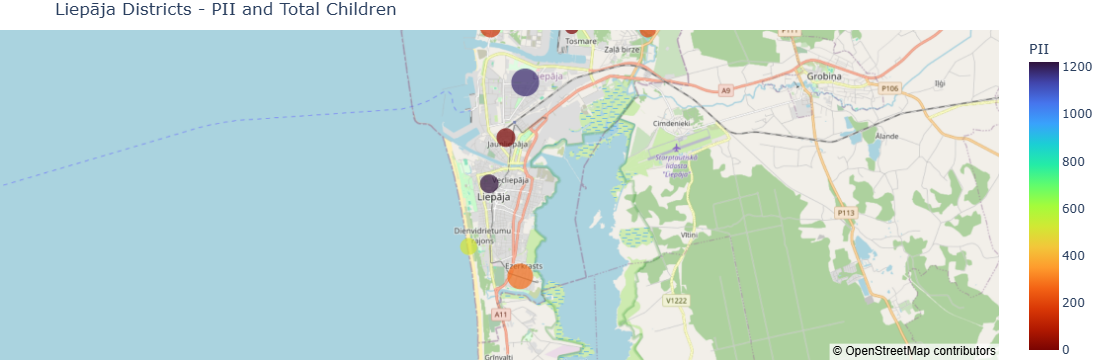

In [84]:
# Create the data dictionary
data_dict = {
    'Rajons': ['Dienvidrietumu', 'Ezerkrasts', 'Vecliepāja', 'Jaunliepāja', 
               'Ziemeļu priekšpilsēta', 'Karosta', 'Tosmare', 'Zaļā birze'],
    'PII': [515, 277, 1220, 0, 1180, 151, 0, 200],
    'Total': [296, 667, 356, 361, 780, 448, 208, 280],
    'latitude': [56.4912, 56.4832, 56.508, 56.5204, 56.53516, 56.55, 56.55, 56.5494],
    'longitude': [20.995, 21.02, 21.005, 21.0131, 21.02246, 21.0056, 21.0451, 21.082]
}

# Create DataFrame
data = pd.DataFrame(data_dict)

# Create figure using plotly express
fig = px.scatter_mapbox(data, 
                       lat='latitude', 
                       lon='longitude',
                       size='Total',  # Size of markers based on Total
                       color='PII',   # Color based on PII
                        color_continuous_scale=px.colors.sequential.Turbo_r,
                       hover_name='Rajons',
                       hover_data=['PII', 'Total'],
                       zoom=10.5,
                       title='Liepāja Districts - PII and Total Children',
                       size_max=20)

# Update layout
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(
        center=dict(lat=56.5050, lon=21.0100)
    ),
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()

In [85]:
# Path to the uploaded .geojson file
geojson_path = "overpass-turbo-Liepaja.geojson"

# Read the file using Fiona
with fiona.open(geojson_path) as src:
    print(src.schema)  # Schema of the GeoJSON
    print(src.crs)     # CRS of the GeoJSON
    print(next(iter(src)))  # Inspect the first feature

    # Convert to a GeoDataFrame while the collection is open
    gdf = gpd.GeoDataFrame.from_features(src, crs=src.crs)

# Inspect the GeoDataFrame
print(gdf.head())

{'properties': {'id': 'str', '@id': 'str', '@relations': 'json', 'ISO3166-2': 'str', 'admin_level': 'str', 'boundary': 'str', 'name': 'str', 'ref': 'str', 'start_date': 'date', 'type': 'str', 'wikidata': 'str'}, 'geometry': 'Unknown'}
EPSG:4326
fiona.Feature(geometry=fiona.Geometry(coordinates=[[(21.0363453, 56.6078383), ...]], type='Polygon'), id='0', properties=fiona.Properties(id='relation/13048685', @id='relation/13048685', @relations=None, ISO3166-2='LV-LPX', admin_level='5', boundary='administrative', name='Liepāja', ref='100003044', start_date='2021-07-01', type='boundary', wikidata='Q167668'))
                                            geometry                 id  \
0  POLYGON ((21.03635 56.60784, 21.03254 56.60841...  relation/13048685   
1                          POINT (21.00709 56.50484)      node/27155834   

                 @id                                         @relations  \
0  relation/13048685                                               None   
1      node/271

                  id                @id  \
0  relation/13048685  relation/13048685   
1      node/27155834      node/27155834   

                                          @relations ISO3166-2 admin_level  \
0                                               None    LV-LPX           5   
1  [ { "role": "label", "rel": 13048685, "reltags...      None        None   

         boundary     name        ref start_date      type wikidata  \
0  administrative  Liepāja  100003044 2021-07-01  boundary  Q167668   
1            None     None       None        NaT      None     None   

                                            geometry  
0  POLYGON ((21.03635 56.60784, 21.03254 56.60841...  
1                          POINT (21.00709 56.50484)  


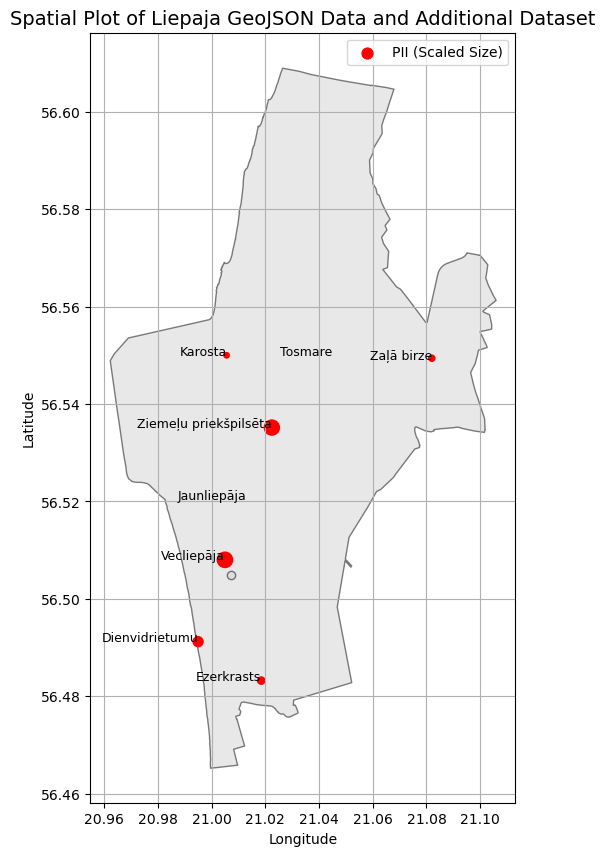

In [32]:
# Load GeoJSON file using GeoPandas (underlying Fiona)
geojson_path = "overpass-turbo-Liepaja.geojson"
with fiona.open(geojson_path) as f:
    crs = f.crs  # Read CRS information
geo_data = gpd.read_file(geojson_path)

# Display GeoJSON file structure
print(geo_data.head())

# Create a DataFrame with the given data
data = {
    'Rajons': ['Dienvidrietumu', 'Ezerkrasts', 'Vecliepāja', 'Jaunliepāja', 
               'Ziemeļu priekšpilsēta', 'Karosta', 'Tosmare', 'Zaļā birze'],
    'PII': [515, 277, 1220, 0, 1180, 151, 0, 200],
    'Total': [296, 667, 356, 361, 780, 448, 208, 280],
    'Latitude': [56.4912, 56.4832, 56.5080, 56.5204, 56.53516, 56.5500, 56.5500, 56.5494],
    'Longitude': [20.9950, 21.0185, 21.0050, 21.0131, 21.022455, 21.0056, 21.0451, 21.0820]
}
df = pd.DataFrame(data)

# Create a GeoDataFrame from the provided data
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the CRS (Coordinate Reference System) explicitly using Fiona's CRS
gdf.set_crs(crs, inplace=True)

# Plot the GeoJSON data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_data.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Add the points from the GeoDataFrame
gdf.plot(ax=ax, color='red', markersize=gdf['PII'] / 10, label='PII (Scaled Size)')

# Annotate each point with its region name
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Rajons']):
    ax.text(x, y, label, fontsize=9, ha='right')

# Add a legend and title
plt.legend()
plt.title("Spatial Plot of Liepaja GeoJSON Data and Additional Dataset", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show the plot
plt.show()

                  id                @id  \
0  relation/13048685  relation/13048685   
1      node/27155834      node/27155834   

                                          @relations ISO3166-2 admin_level  \
0                                               None    LV-LPX           5   
1  [ { "role": "label", "rel": 13048685, "reltags...      None        None   

         boundary     name        ref start_date      type wikidata  \
0  administrative  Liepāja  100003044 2021-07-01  boundary  Q167668   
1            None     None       None        NaT      None     None   

                                            geometry  
0  POLYGON ((21.03635 56.60784, 21.03254 56.60841...  
1                          POINT (21.00709 56.50484)  


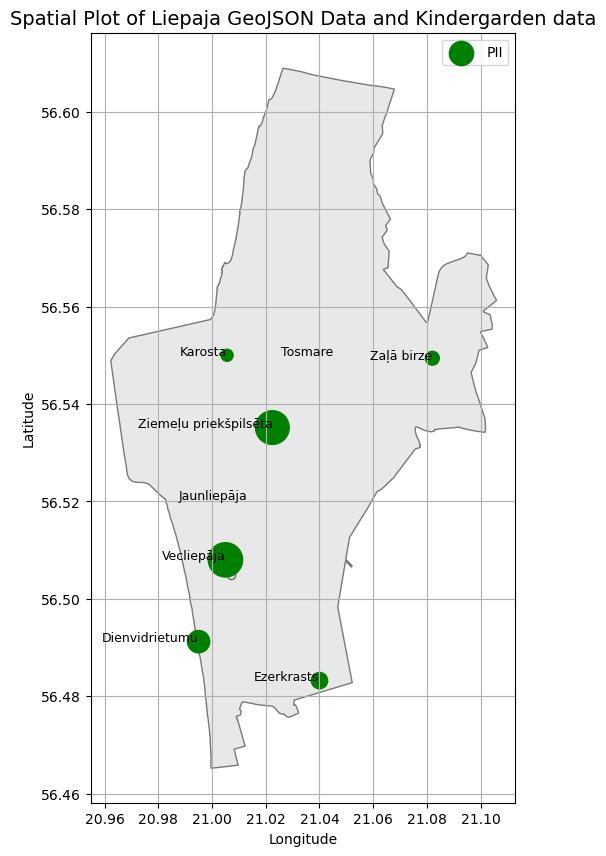

In [87]:
# Load GeoJSON file using GeoPandas
# geo_data = gpd.read_file(geojson_path, engine="fiona")  # Force Fiona as the backend if Pygrio doesn't work
geojson_path = "overpass-turbo-Liepaja.geojson"
geo_data = gpd.read_file(geojson_path)

# Display GeoJSON fi

# Display GeoJSON file structure
print(geo_data.head(5))

# Create a DataFrame with the given data
data = {
    'Rajons': ['Dienvidrietumu', 'Ezerkrasts', 'Vecliepāja', 'Jaunliepāja', 
               'Ziemeļu priekšpilsēta', 'Karosta', 'Tosmare', 'Zaļā birze'],
    'PII': [515, 277, 1220, 0, 1180, 151, 0, 200],
    'Total': [296, 667, 356, 361, 780, 448, 208, 280],
    'Latitude': [56.4912, 56.4832, 56.5080, 56.5204, 56.53516, 56.5500, 56.5500, 56.5494],
    'Longitude': [20.9950, 21.04, 21.0050, 21.0131, 21.022455, 21.0056, 21.0451, 21.0820]
}
df = pd.DataFrame(data)

# Create a GeoDataFrame from the provided data
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the CRS (Coordinate Reference System) to match the GeoJSON file
gdf.crs = geo_data.crs

# Plot the GeoJSON data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_data.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Add the points from the GeoDataFrame
gdf.plot(ax=ax, color='green', markersize=gdf['PII'] / 2, label='PII')

# Annotate each point with its region name
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Rajons']):
    ax.text(x, y, label, fontsize=9, ha='right')

# Add a legend and title
plt.legend()
plt.title("Spatial Plot of Liepaja GeoJSON Data and Kindergarden data", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Show the plot
plt.show()

In [37]:
print("GeoDataFrame columns:", geo_data.columns)
print("DataFrame columns:", df.columns)
geo_data.head()

GeoDataFrame columns: Index(['id', '@id', '@relations', 'ISO3166-2', 'admin_level', 'boundary',
       'name', 'ref', 'start_date', 'type', 'wikidata', 'geometry'],
      dtype='object')
DataFrame columns: Index(['Rajons', 'PII', 'Total', 'Latitude', 'Longitude'], dtype='object')


,id,@id,@relations,ISO3166-2,admin_level,boundary,name,ref,start_date,type,wikidata,geometry
0,relation/13048685,relation/13048685,None,LV-LPX,5,administrative,Liepāja,100003044,2021-07-01,boundary,Q167668,"POLYGON ((21.03635 56.60784, 21.03254 56.60841..."
1,node/27155834,node/27155834,"[ { ""role"": ""label"", ""rel"": 13048685, ""reltags...",None,None,None,None,None,NaT,None,None,POINT (21.00709 56.50484)


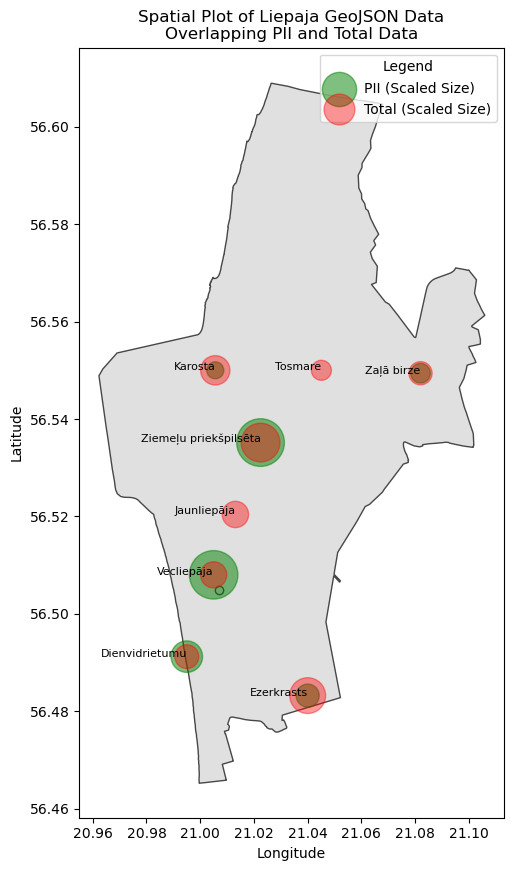

In [39]:
# 1. Create a GeoDataFrame for Neighborhoods. Use the coordinates to create point geometries for each neighborhood.
# Data for neighborhoods
data = {
    'Rajons': ['Dienvidrietumu', 'Ezerkrasts', 'Vecliepāja', 'Jaunliepāja', 
               'Ziemeļu priekšpilsēta', 'Karosta', 'Tosmare', 'Zaļā birze'],
    'PII': [515, 277, 1220, 0, 1180, 151, 0, 200],
    'Total': [296, 667, 356, 361, 780, 448, 208, 280],
    'Latitude': [56.4912, 56.4832, 56.5080, 56.5204, 56.53516, 56.5500, 56.5500, 56.5494],
    'Longitude': [20.9950, 21.04, 21.0050, 21.0131, 21.022455, 21.0056, 21.0451, 21.0820]
}

# Create a GeoDataFrame for the neighborhoods
df = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['Longitude'], data['Latitude']), crs="EPSG:4326")

# 2. Ensure GeoJSON File Has Polygons in Correct CRS
# Load the GeoJSON data and verify that it is in the same coordinate reference system (EPSG:4326) as the neighborhood data.
# Load GeoJSON file
geo_data = gpd.read_file("overpass-turbo-Liepaja.geojson")

# Ensure the CRS matches
if geo_data.crs != "EPSG:4326":
    geo_data = geo_data.to_crs("EPSG:4326")

# 3. Perform Spatial Join to assign each neighborhood point to the polygon (if applicable).
result = gpd.sjoin(df, geo_data, how="left", predicate="within")


# Plot GeoJSON data (polygons)
fig, ax = plt.subplots(figsize=(10, 10))
geo_data.plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.7)

# Plot neighborhood points scaled by 'PII' (e.g., red circles)
result.plot(
    ax=ax,
    color="green",
    markersize=result["PII"],
    label="PII (Scaled Size)",
    alpha=0.5,
)

# Plot neighborhood points scaled by 'Total' (e.g., blue circles)
result.plot(
    ax=ax,
    color="red",
    markersize=result["Total"],
    label="Total (Scaled Size)",
    alpha=0.4,
)

# Annotate neighborhoods
for x, y, label in zip(result.geometry.x, result.geometry.y, result["Rajons"]):
    ax.text(x, y, label, fontsize=8, ha='right', color="black")

# Add title, labels, and legend
plt.title("Spatial Plot of Liepaja GeoJSON Data\nOverlapping PII and Total Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Legend")
plt.show()

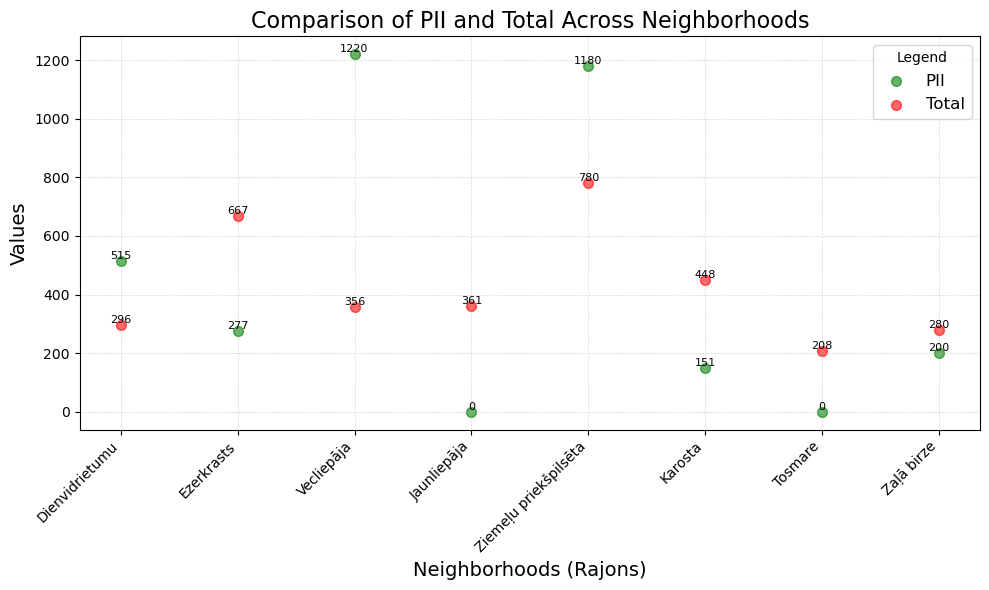

In [60]:
# Data from the provided table
data = {
    'Rajons': ['Dienvidrietumu', 'Ezerkrasts', 'Vecliepāja', 'Jaunliepāja',
               'Ziemeļu priekšpilsēta', 'Karosta', 'Tosmare', 'Zaļā birze'],
    'PII': [515, 277, 1220, 0, 1180, 151, 0, 200],
    'Total': [296, 667, 356, 361, 780, 448, 208, 280]
}

df = pd.DataFrame(data)

# Normalize data for bubble chart
df['PII_scaled'] = df['PII'] / max(df['PII']) * 100
df['Total_scaled'] = df['Total'] / max(df['Total']) * 100

# Bubble chart setup
fig, ax = plt.subplots(figsize=(10,6))

# Scatter plot for PII and Total
scatter1 = ax.scatter(df['Rajons'], df['PII'], s=50, c='green', alpha=0.6, label='PII')
scatter2 = ax.scatter(df['Rajons'], df['Total'], s=50, c='red', alpha=0.6, label='Total')

# Adding labels
for i, row in df.iterrows():
    ax.text(row['Rajons'], row['PII'], f"{row['PII']}", fontsize=8, ha='center', va='bottom', color='black')
    ax.text(row['Rajons'], row['Total'], f"{row['Total']}", fontsize=8, ha='center', va='bottom', color='black')

# Chart formatting
ax.set_title("Comparison of PII and Total Across Neighborhoods", fontsize=16)
ax.set_ylabel("Values", fontsize=14)
ax.set_xlabel("Neighborhoods (Rajons)", fontsize=14)
ax.set_xticks(df['Rajons'])
ax.set_xticklabels(df['Rajons'], rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper right', fontsize=12, title="Legend")
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()